# Introduction

Notebook to explore the use of pade approximants. Example given as applied to the expansion of the generating function of the Legrende polynomials. 

In [8]:
# import necessary libraries
import math
import scipy.special
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# set custom plotting values
mpl.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20 
mpl.rcParams['ytick.labelsize'] = 20 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['lines.markersize'] = 1000
mpl.rcParams['legend.fontsize'] = 18

Consider the generating function of the Legendre polynomials. It can be drived by considering the mangitude of the vector difference between two three-dimensional vectors, $\vec{r}, \vec{r}'$ as often arises in problems involving gravity and EM:

$$\frac{1}{|\vec{r} - \vec{r}'|} = \frac{1}{\sqrt{r^2 + r'^2 - 2rr'  \cos(\theta)}}$$

where $\cos(\theta)$ is the angle between the two vectors. Rearranging the above with $z = \frac{r'}{r}$ and $x = \cos(\theta)$, we get the generating function $\alpha(x,z)$:

$$\frac{1}{r} \frac{1}{\sqrt{1 - 2 z x + z^2}} = \frac{1}{r} \ \alpha(x,z)$$

The coefficients of the Taylor expansion in $z$ of the generating function $\alpha(x,z)$ are Legendre Polynomials $L_n(x)$,

$$\frac{1}{\sqrt{1 - 2 z x + z^2}} = \sum_{n=0}^{\infty} L_n(x) \ z^n$$

To simplify things, set the $x$ variable in the generating function to a constant value, say 0.5:

$$ x = x_0 = 0.5 \implies \alpha(x_0,z) = \sum_{n=0}^{\infty} L_n(x_0) \ z^n$$

The $[m,n]$ pade approximant to a function is a rational function of the form:

$$\alpha(z) = \frac{P_m(z)}{Q_n(z)}$$

where $P_m(z)$ and $Q_n(z)$ are both polynomials:

$$P_m(z) = \sum_{i=0}^{m} p_i \ z^i  \qquad  Q_n(z) = \sum_{i=0}^{n} q_i \ z^i$$

The $p_i$ and $q_i$ coefficients form a coupled set of equations which are determined purely from the Taylor series expansion coefficients. Expanding out the Taylor series to $j$ terms, all Pade approximants $[m,n]$ can be formed subject to the maximal restriction of $j = m + n$.  To quote why to use a Pade approximant over a simple Taylor expansion (see Ref. 1):

> Polynomials are not such a good class of functions if one wants to approximate functions with
singularities because polynomials are entire functions without singularities. They are only useful up
to the first singularity of f near a. Rational functions are the simplest functions with singularities.
The idea is that the poles of the rational functions will move to the singularities of the function f,
and hence the domain of convergence could be enlarged, and singularities of f may be discovered
using the poles of the rational approximants.}

Pade approximants can also show convergence behavior well outside of the radius of convergence of the Taylor expansion as will be seen below. 

# Function Definitions

In [9]:
# legendre generating function assuming x = 0.5
def generating_func(z):
    
    x = 0.5
    value = math.sqrt(1 - 2*x*z + math.pow(z,2))
    return (1./value)

# function to get the taylor expansion of the generating function
def generating_func_expansion(z, n, taylor_coeff_func):
    
    expansion_sum = 0
    
    for a in range(0,n+1):
        expansion_sum += (taylor_coeff_func(a) * math.pow(z,a))
        
    return expansion_sum

# get nth taylor expansion coefficient (assuming x = 0.5)
def taylor_coeff_func_legendre(n):
    x = 0.5
    return scipy.special.legendre(n)(x)

In [10]:
# get array of taylor expansion coefficients
def get_array_taylor_coeff(order, taylor_coeff_func):
    taylor_coeffs = np.zeros(order)
    
    for n in range (0, order):
        taylor_coeffs[n] = taylor_coeff_func(n)
    
    return taylor_coeffs

In [11]:
# function to return the sum of a power series in x^n
def get_pade_polynomial(coeffs, x, order):    
    pade_sum = 0
    
    for idx in range(0, order+1):
        term = coeffs[idx] * math.pow(x, idx)
        pade_sum += term

    return pade_sum

# create the coupled equation matrix to determine pade approximant coefficients for [n,n]
def create_pade_matrix(taylor_coeffs, order):
    
    pade_matrix = np.zeros((order+1, order+1))
    
    qIdxStart = int(order/2 + 1)
        
    # set diagonal element
    for idx in range(0, qIdxStart):
        pade_matrix[idx,idx] = -1
    
    for row in range (0, order+1):
        taylorIdx = row - 1
                        
        for qIdx in range (0, row):
            qMatrixIdx = qIdxStart + qIdx
            
            if (qMatrixIdx > order):
                continue
            
            pade_matrix[row, qMatrixIdx] = taylor_coeffs[taylorIdx]
            taylorIdx -= 1
            
                        
    return pade_matrix   

In [12]:
# return the [n,n] pade approximant
def pade_approximant(z, order, taylor_coeff_func):
        
    pade_order = int(order/2)

    taylor_coeffs = get_array_taylor_coeff(order+1, taylor_coeff_func)
    pade_matrix = create_pade_matrix(taylor_coeffs, order)
    a = pade_matrix
    b = -1 * taylor_coeffs
    pade_coeffs = np.linalg.solve(a, b)

    p_coeffs = pade_coeffs[0:pade_order+1]
    q_coeffs = np.zeros(pade_order + 1)
    q_coeffs[0] = 1
    qIdx = 1
    for idx in range(pade_order + 1, order+1):
        q_coeffs[qIdx] = pade_coeffs[idx]
        qIdx += 1

    pade_numer = get_pade_polynomial(p_coeffs, z, pade_order)
    pade_denom = get_pade_polynomial(q_coeffs, z, pade_order)
    
    return (pade_numer / pade_denom)

# Application

Now we check the behavior of the $[m,n]$ pade approximant to the Legendre generating function versus the Taylor expansion. For simplicity, I restrict myself to look at only the diagonal Pade approximant where $m=n$.

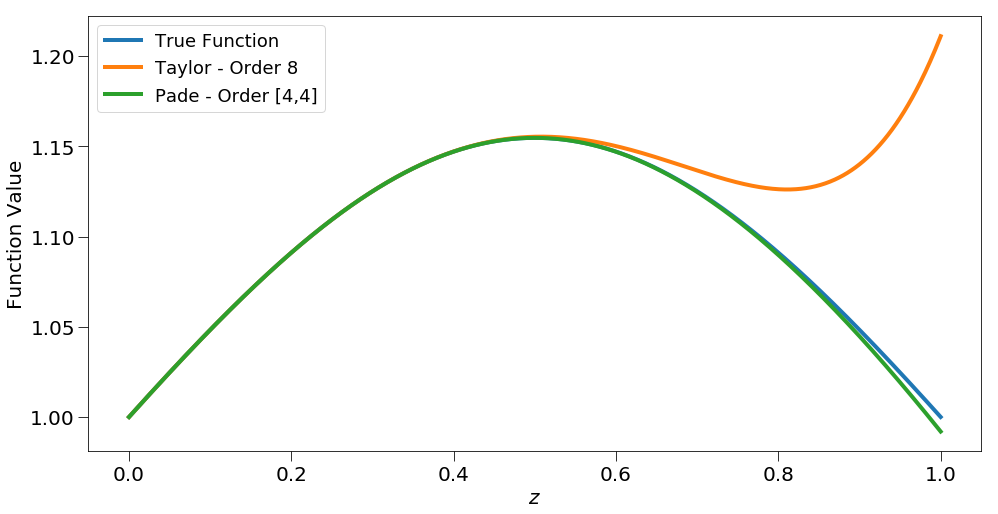

In [13]:
z_vals = np.linspace(0, 1, 1000)

order = 8

func_vals = [generating_func(z) for z in z_vals]
legr_vals = [generating_func_expansion(z, order, taylor_coeff_func_legendre) for z in z_vals]
pade_vals = [pade_approximant(z, order, taylor_coeff_func_legendre) for z in z_vals]

plt.plot(z_vals, func_vals, label = 'True Function')
plt.plot(z_vals, legr_vals, label = str.format('Taylor - Order %d' % order))
plt.plot(z_vals, pade_vals, label = str.format('Pade - Order [%d,%d]' % (order/2, order/2)))
plt.xlabel("$z$")
plt.ylabel("Function Value")
plt.legend()

As one can see, the Taylor expansion starts to diverge around the point $z=1$ where the $z$ terms of the power series all become of the same order. In contrast, the $[n,n]$ Pade approximant still gives a quality approximation to the function even at this point. It is emphasized that the information used to compute the Pade approximant is the *same* as that which went into the Taylor expansion.

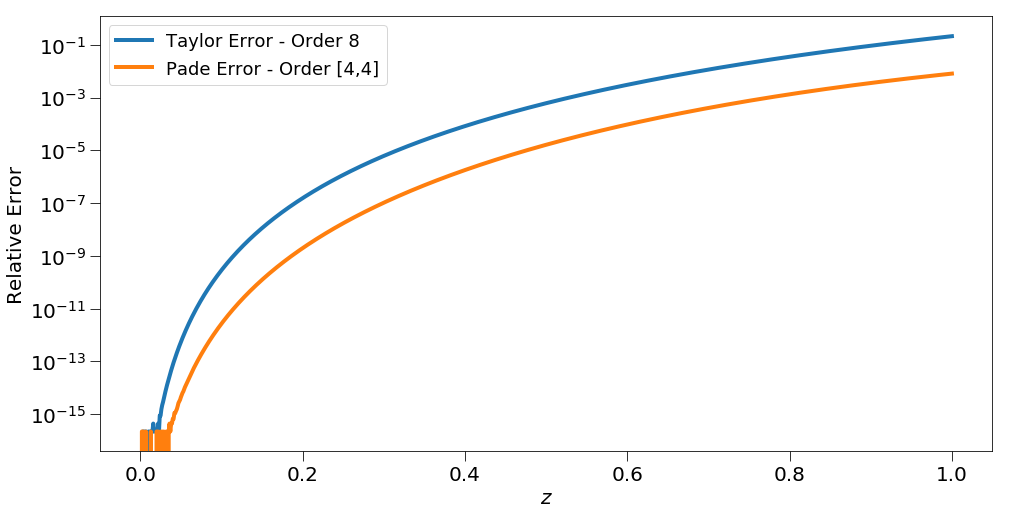

In [14]:
taylor_diff = [abs(t - f) for t,f in zip(legr_vals, func_vals)]
pade_diff = [abs(p - f) for p,f in zip(pade_vals, func_vals)]
plt.plot(z_vals, taylor_diff, label = str.format('Taylor Error - Order %d' % order))
plt.plot(z_vals, pade_diff, label = str.format('Pade Error - Order [%d,%d]' % (order/2, order/2)))
plt.ylabel("Relative Error")
plt.xlabel("$z$")
plt.yscale('log')
plt.legend()

The relative error plot demonstrates the utilty of the Pade approach as well. Even at values well within the Taylor expansion radius of convergence, the Pade approximant shows a lower relative error than the Taylor expansion by at least an order of magnitude. 

# References

1. Pade and Hermite-Pade approximation and orthogonality - Walter Van Assche - https://arxiv.org/abs/math/0609094
2. Blog Post - https://www.avrahamadler.com/2015/06/04/a-practical-example-of-calculating-pade-approximant-coefficients-using-r/
3. Pade-resummed high-order perturbation theory for nuclear structure calculations - Robert Roth and Joachim Langhammer - https://arxiv.org/abs/0910.3650